# MobileNet V2

### Imports

In [2]:
import numpy as np
from glob import glob
import os
import cv2


from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model,load_model, Sequential
from tensorflow.keras.layers import  GlobalAveragePooling2D, Dropout, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Data Paths

In [3]:
train_path = '/kaggle/input/intel-image-classification-mobilenet/seg_train/seg_train'
test_path = '/kaggle/input/intel-image-classification-mobilenet/seg_test/seg_test'

### Load Data

In [24]:
image_size = (150, 150) # 150x150 pixels

def load_images(path):
    X = []
    y = []

    folders = sorted(os.listdir(path), key=lambda x: os.path.getmtime(os.path.join(path, x)))

    for i, folder in enumerate(folders):
        for file in os.listdir(os.path.join(path, folder)):
            img = cv2.imread(os.path.join(path, folder, file))
            img = cv2.resize(img, image_size)
            X.append(img)
            y.append(i)

    return np.array(X), np.array(y)

X_train, y_train = load_images(train_path)
X_test, y_test = load_images(test_path)

### Number of Classes

In [25]:
numberOfClass = len(glob(train_path + "/*"))
print("Number Of Class: ", numberOfClass)

Number Of Class:  6


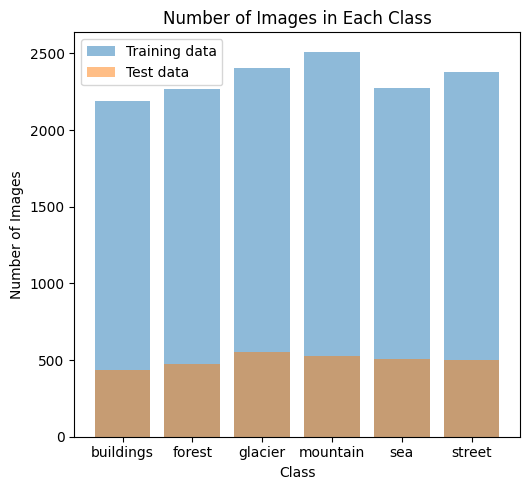

In [26]:
labels = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(*np.unique(y_train, return_counts=True), label='Training data', alpha=0.5)
plt.bar(*np.unique(y_test, return_counts=True), label='Test data', alpha=0.5)
plt.title('Number of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(range(len(labels)), labels.values())
plt.legend()
plt.tight_layout()
plt.show()

### Show Data

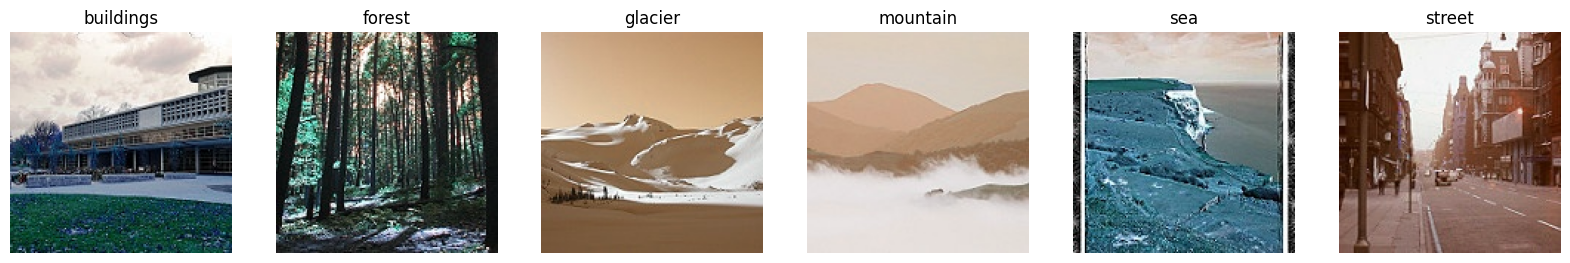

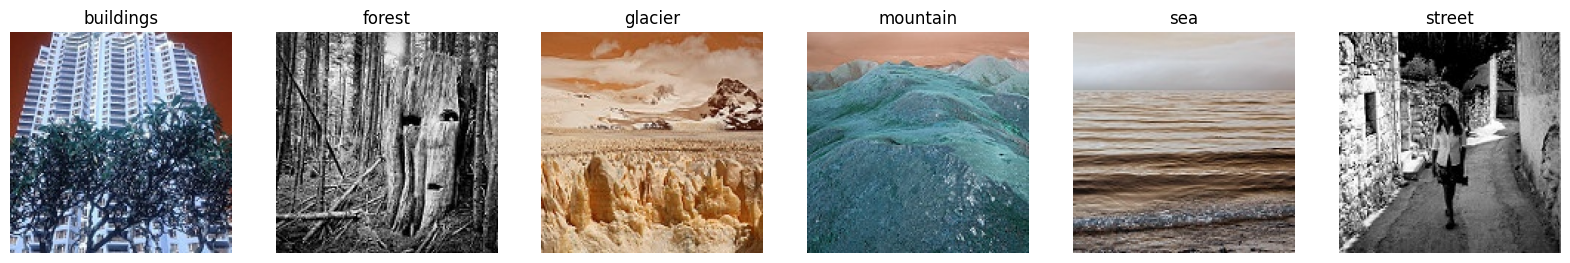

In [27]:
fig, axes = plt.subplots(1, 6, figsize=(20, 20))
for i in range(6):
    axes[i].imshow(X_train[y_train == i][0])
    axes[i].set_title(labels[i])
    axes[i].axis('off')
plt.show()

# display some images from the test data per class
fig, axes = plt.subplots(1, 6, figsize=(20, 20))
for i in range(6):
    axes[i].imshow(X_test[y_test == i][0])
    axes[i].set_title(labels[i])
    axes[i].axis('off')
plt.show()

### Split Training and Validation Data

In [28]:
# one-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# split the training data into training and validation data
# 80% of the data will be used for training and 20% for validation
# split the data stratified by the labels
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [29]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

(11227, 150, 150, 3)
(11227, 6)
(2807, 150, 150, 3)
(2807, 6)


### Normalize Data

In [30]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Model Architecture MobileNet V2

In [45]:
mobileNet = tf.keras.applications.MobileNetV2(input_shape=(150,150,3), include_top=False,weights='/kaggle/input/mobilenetv2/tensorflow2/mobilenet/1/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')

In [46]:
for layer in mobileNet.layers:
    layer.trainable = False

In [47]:
model = Sequential()
model.add(mobileNet)
model.add(GlobalAveragePooling2D())
model.add(Dense(6, activation="softmax"))

In [48]:
model.build((None, 150, 150, 3))
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_150            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [49]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = "categorical_crossentropy", metrics = ["accuracy"])

### Train Model

In [50]:
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val))


Epoch 1/15
 10/351 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.1493 - loss: 2.6049

W0000 00:00:1718634344.797567    2394 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4425 - loss: 1.5062

W0000 00:00:1718634352.740246    2395 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718634358.800970    2395 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - accuracy: 0.4429 - loss: 1.5049 - val_accuracy: 0.7912 - val_loss: 0.5599
Epoch 2/15
  7/351 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8089 - loss: 0.4965

W0000 00:00:1718634362.175822    2392 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.8215 - loss: 0.4959 - val_accuracy: 0.8436 - val_loss: 0.4241
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.8564 - loss: 0.3932 - val_accuracy: 0.8607 - val_loss: 0.3781
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.8772 - loss: 0.3428 - val_accuracy: 0.8717 - val_loss: 0.3563
Epoch 5/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.8783 - loss: 0.3440 - val_accuracy: 0.8764 - val_loss: 0.3453
Epoch 6/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.8849 - loss: 0.3139 - val_accuracy: 0.8789 - val_loss: 0.3338
Epoch 7/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.8919 - loss: 0.3013 - val_accuracy: 0.8817 - val_loss: 0.3254
Epoch 8/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9005 - loss: 0.2815 - val_accuracy: 0.8828 - val_loss: 0.3210
Epoch 9/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.8980 - loss: 0.2792 - val_accuracy: 0.889

## Performance metrics

### Accuracy and Loss

In [51]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(15, 10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], label = "Train Accuracy")
    plt.plot(history.history['val_accuracy'], label = "Validation Accuracy")
    plt.title("Train Accuracy vs Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'], label = "Train Loss")
    plt.plot(history.history['val_loss'], label = "Validation Loss")
    plt.title("Train Loss vs Validation Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")

    plt.legend()
    plt.show()

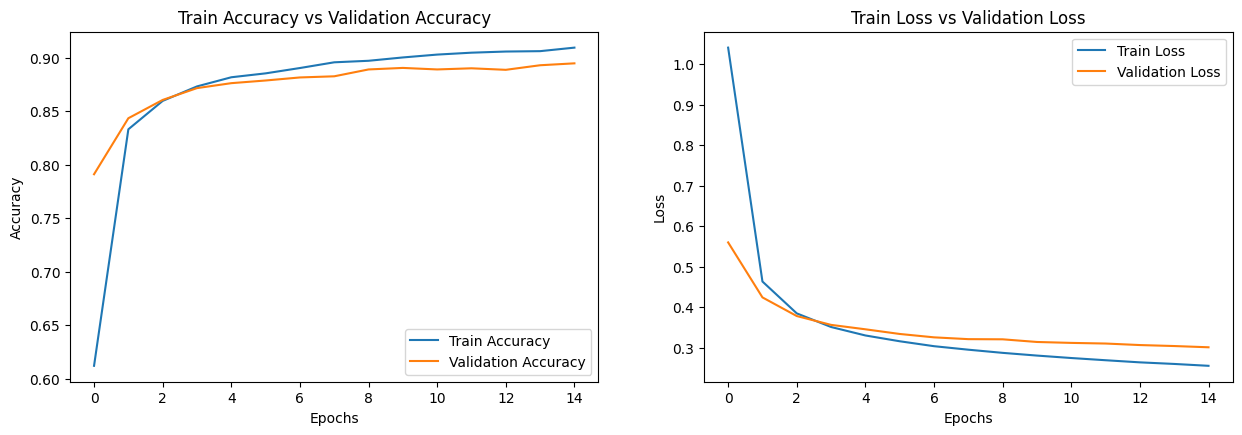

In [52]:
plot_accuracy_loss(history)

### Classification Report and Confusion Matrix

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       437
           1       0.99      0.99      0.99       474
           2       0.81      0.81      0.81       553
           3       0.81      0.77      0.79       525
           4       0.88      0.90      0.89       510
           5       0.92      0.92      0.92       501

    accuracy                           0.88      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.88      0.88      0.88      3000



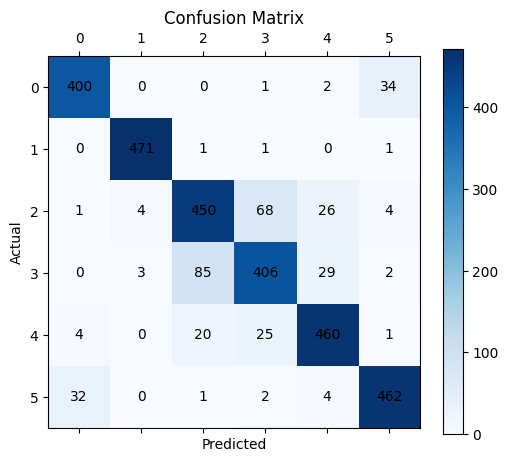

In [53]:
# Confusion Matrix
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  
confusion = confusion_matrix(true_labels, y_pred)

fig, ax = plt.subplots(figsize=(6, 5)) 
cax = ax.matshow(confusion, cmap='Blues')
fig.colorbar(cax)

print(classification_report(true_labels, y_pred))

for (i, j), val in np.ndenumerate(confusion):
    ax.text(j, i, f'{val}', ha='center', va='center')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Accuracy of Training, Validation and Testing data

In [54]:
print("Accuracy of the model using training data is - ", model.evaluate(X_train,y_train)[1]*100,"%")
print("Accuracy of the model using validation data is - ", model.evaluate(X_val,y_val)[1]*100,"%")
print("\nAccuracy of the model is - ", model.evaluate(X_test,y_test)[1]*100,"%")

351/351 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9136 - loss: 0.2473


W0000 00:00:1718634502.859997    2395 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Accuracy of the model using training data is -  91.23541712760925 %
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8925 - loss: 0.2862
Accuracy of the model using validation data is -  89.49055671691895 %
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8992 - loss: 0.2762

Accuracy of the model is -  88.30000162124634 %


W0000 00:00:1718634512.169373    2394 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### Plot ROC Curves

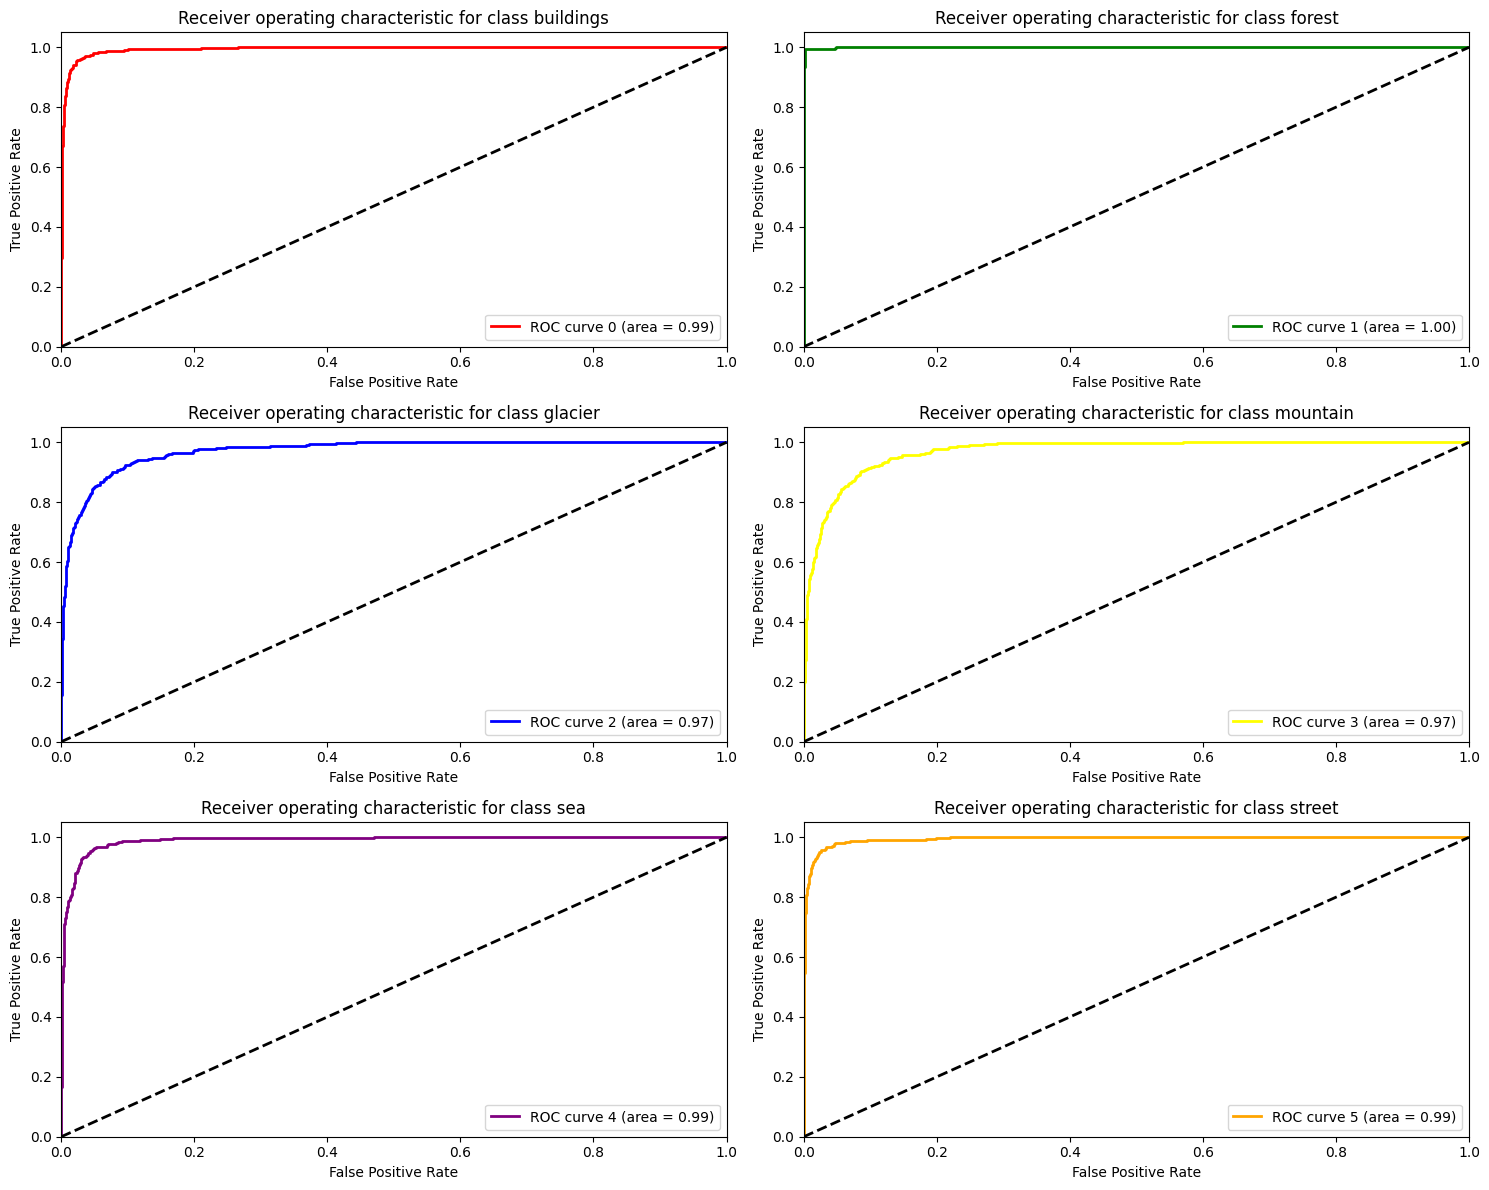

In [55]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

unique_classes = [0, 1, 2, 3, 4, 5]

y_train_bin = label_binarize(y_train, classes=unique_classes)
y_test_bin = label_binarize(y_test, classes=unique_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(unique_classes)

# Criação de figuras e subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 12))  # 3 linhas, 2 colunas

# Cores para as classes
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange']

# Iteração sobre todas as classes
for i, ax in enumerate(axs.flat):
    # Seleciona a classe atual
    class_index = i % num_classes
    
    # Calcula FPR, TPR e AUC para a classe atual
    fpr[class_index], tpr[class_index], _ = roc_curve(y_test_bin[:, class_index], predictions[:, class_index])
    roc_auc[class_index] = auc(fpr[class_index], tpr[class_index])
    
    # Plota a curva ROC
    ax.plot(fpr[class_index], tpr[class_index], color=colors[class_index % len(colors)], lw=2,
            label=f'ROC curve {class_index} (area = {roc_auc[class_index]:.2f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic for class {}'.format(labels.get(class_index)))
    ax.legend(loc="lower right")

plt.tight_layout()  
plt.show()

# MobileNet V2 with More Layers and SGD

In [17]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

mobileNet2 = tf.keras.applications.MobileNetV2(input_shape=(150,150,3), include_top= False,weights='/kaggle/input/mobilenetv2/tensorflow2/mobilenet/1/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')


mobileNet2.trainable = True

#define model
model2 = tf.keras.Sequential()
model2.add(mobileNet2)
model2.add(tf.keras.layers.GlobalAveragePooling2D())
model2.add(tf.keras.layers.Dense(1024, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(512, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(6, activation='softmax'))
#compile model
model2.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=SGD(learning_rate=0.0001, momentum=0.9, nesterov=True, weight_decay=0.001))

model2.build((None, 150, 150, 3))
model2.summary()
    


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_150            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,097,606 (15.63 MB)

 Trainable params: 4,063,494 (15.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

## Train Model

In [18]:
history = model2.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val))

Epoch 1/15
  2/351 ━━━━━━━━━━━━━━━━━━━━ 29s 85ms/step - accuracy: 0.1484 - loss: 2.5600   

W0000 00:00:1718633695.401963    2394 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.2442 - loss: 1.9684

W0000 00:00:1718633731.730835    2395 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718633737.169445    2395 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 79s 128ms/step - accuracy: 0.2445 - loss: 1.9675 - val_accuracy: 0.7353 - val_loss: 0.8095
Epoch 2/15
  2/351 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.5469 - loss: 1.0545

W0000 00:00:1718633740.147276    2395 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.6150 - loss: 1.0100 - val_accuracy: 0.8354 - val_loss: 0.4614
Epoch 3/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.7776 - loss: 0.6223 - val_accuracy: 0.8660 - val_loss: 0.3622
Epoch 4/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.8293 - loss: 0.4896 - val_accuracy: 0.8903 - val_loss: 0.3224
Epoch 5/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.8654 - loss: 0.3985 - val_accuracy: 0.8970 - val_loss: 0.3046
Epoch 6/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.8782 - loss: 0.3552 - val_accuracy: 0.8999 - val_loss: 0.2974
Epoch 7/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.8833 - loss: 0.3418 - val_accuracy: 0.9045 - val_loss: 0.2828
Epoch 8/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.8965 - loss: 0.3044 - val_accuracy: 0.9109 - val_loss: 0.2720
Epoch 9/15
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.9038 - loss: 0.2863 - val_accurac

## Performance metrics

### Accuracy and Loss

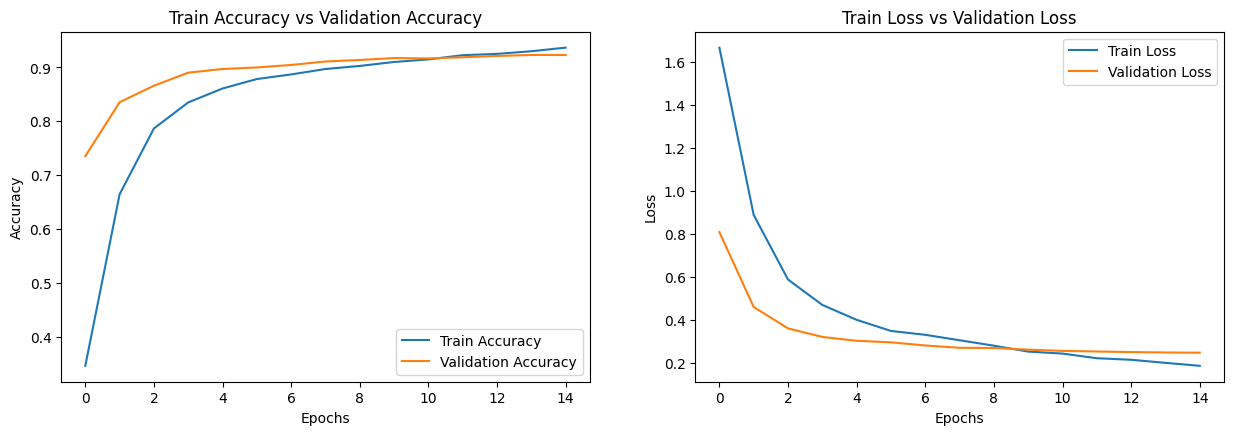

In [19]:
plot_accuracy_loss(history)

### Classification Report and Confusion Matrix

13/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

W0000 00:00:1718634072.321900    2392 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step


W0000 00:00:1718634079.197629    2394 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


              precision    recall  f1-score   support

           0       0.92      0.93      0.93       437
           1       0.98      0.99      0.99       474
           2       0.86      0.86      0.86       553
           3       0.88      0.86      0.87       525
           4       0.93      0.94      0.94       510
           5       0.93      0.93      0.93       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



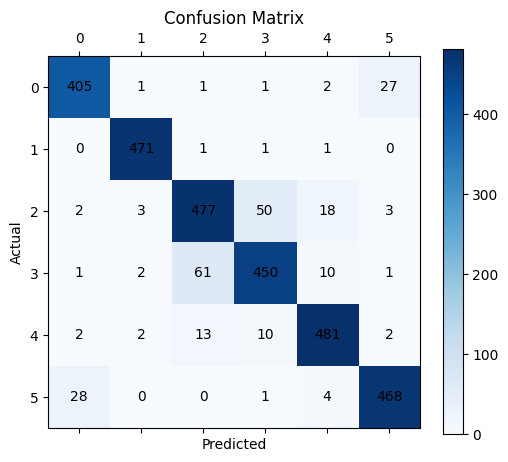

In [21]:
# Confusion Matrix
predictions = model2.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  
confusion = confusion_matrix(true_labels, y_pred)

fig, ax = plt.subplots(figsize=(6, 5)) 
cax = ax.matshow(confusion, cmap='Blues')
fig.colorbar(cax)

print(classification_report(true_labels, y_pred))

for (i, j), val in np.ndenumerate(confusion):
    ax.text(j, i, f'{val}', ha='center', va='center')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Accuracy of Training, Validation and Testing data

In [22]:
print("Accuracy of the model using training data is - ", model2.evaluate(X_train,y_train)[1]*100,"%")
print("Accuracy of the model using validation data is - ", model2.evaluate(X_val,y_val)[1]*100,"%")
print("\nAccuracy of the model is - ", model2.evaluate(X_test,y_test)[1]*100,"%")

351/351 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9698 - loss: 0.0867


W0000 00:00:1718634111.951530    2395 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Accuracy of the model using training data is -  97.04284071922302 %
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9194 - loss: 0.2392
Accuracy of the model using validation data is -  92.30495095252991 %
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9212 - loss: 0.2272


W0000 00:00:1718634121.243214    2392 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Accuracy of the model is -  91.73333048820496 %


### Plot ROC Curves

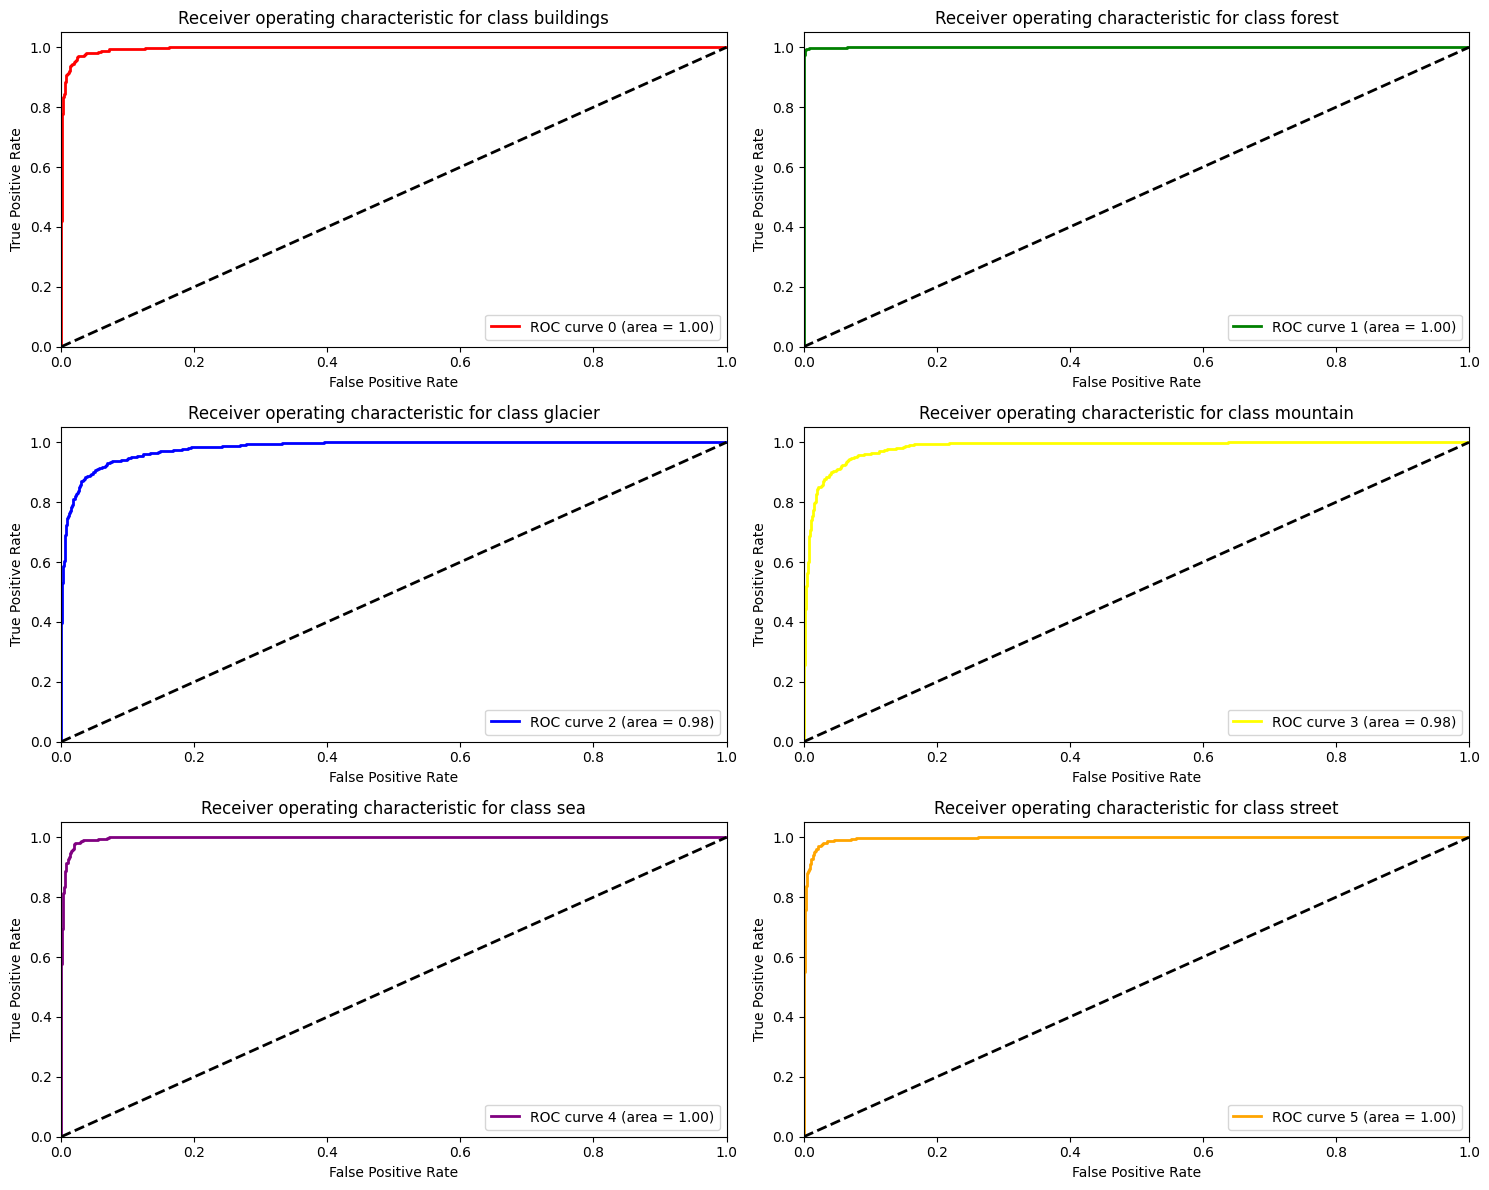

In [23]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

unique_classes = [0, 1, 2, 3, 4, 5]

y_train_bin = label_binarize(y_train, classes=unique_classes)
y_test_bin = label_binarize(y_test, classes=unique_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(unique_classes)

# Criação de figuras e subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 12))  # 3 linhas, 2 colunas

# Cores para as classes
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange']

# Iteração sobre todas as classes
for i, ax in enumerate(axs.flat):
    # Seleciona a classe atual
    class_index = i % num_classes
    
    # Calcula FPR, TPR e AUC para a classe atual
    fpr[class_index], tpr[class_index], _ = roc_curve(y_test_bin[:, class_index], predictions[:, class_index])
    roc_auc[class_index] = auc(fpr[class_index], tpr[class_index])
    
    # Plota a curva ROC
    ax.plot(fpr[class_index], tpr[class_index], color=colors[class_index % len(colors)], lw=2,
            label=f'ROC curve {class_index} (area = {roc_auc[class_index]:.2f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic for class {}'.format(labels.get(class_index)))
    ax.legend(loc="lower right")

plt.tight_layout()  
plt.show()